# Self-Driving Car Engineer Nanodegree

## Deep Learning and Convolutional Neural Networks 

## Project: Build a Traffic Sign Recognition Classifier



---
## Step 0: Load The Data

In [4]:
import pickle
import os

training_file = './traffic-signs-data/train.p'
validation_file= './traffic-signs-data/valid.p'
testing_file = './traffic-signs-data/test.p'

with open(training_file, mode='rb') as f:
    train = pickle.load(f)
with open(validation_file, mode='rb') as f:
    valid = pickle.load(f)
with open(testing_file, mode='rb') as f:
    test = pickle.load(f)
    
X_train, y_train = train['features'], train['labels']
X_valid, y_valid = valid['features'], valid['labels']
X_test, y_test = test['features'], test['labels']

assert(len(X_train) == len(y_train))
assert(len(X_valid) == len(y_valid))
assert(len(X_test) == len(y_test))

print()
print("Image Shape: {}".format(X_train[0].shape))
print()
print("Training Set:   {} samples".format(len(X_train)))
print("Validation Set: {} samples".format(len(X_valid)))
print("Test Set:       {} samples".format(len(X_test)))


Image Shape: (32, 32, 3)

Training Set:   34799 samples
Validation Set: 4410 samples
Test Set:       12630 samples


---

## Step 1: Dataset Summary & Exploration

The pickled data is a dictionary with 4 key/value pairs:

- `'features'` is a 4D array containing raw pixel data of the traffic sign images, (num examples, width, height, channels).
- `'labels'` is a 1D array containing the label/class id of the traffic sign. The file `signnames.csv` contains id -> name mappings for each id.
- `'sizes'` is a list containing tuples, (width, height) representing the original width and height the image.
- `'coords'` is a list containing tuples, (x1, y1, x2, y2) representing coordinates of a bounding box around the sign in the image. **THESE COORDINATES ASSUME THE ORIGINAL IMAGE. THE PICKLED DATA CONTAINS RESIZED VERSIONS (32 by 32) OF THESE IMAGES**



### Provide a Basic Summary of the Data Set Using Python, Numpy and/or Pandas

In [5]:
import numpy as np

# Number of training examples
n_train = format(len(X_train))

# Number of validation examples
n_validation = format(len(X_valid))

# Number of testing examples
n_test = format(len(X_test))

# Shape of an traffic sign image
image_shape = format(X_train[0].shape)

# Unique classes/labels in the dataset.
n_classes = len(np.unique(y_train))

print()
print("Number of training examples =", n_train)
print("Number of validation examples =", n_validation)
print("Number of testing examples =", n_test)
print()
print("Image data shape =", image_shape)
print("Number of classes =", n_classes)


Number of training examples = 34799
Number of validation examples = 4410
Number of testing examples = 12630

Image data shape = (32, 32, 3)
Number of classes = 43


In [6]:
# Combining the training and validation dataset in order to gain more images in the preprocessing stage
# Later the validation will be Cut back (20%) from the training set
X_train = np.concatenate([X_train, X_valid])
y_train = np.concatenate([y_train, y_valid])
print(X_train.shape, y_train.shape)


(39209, 32, 32, 3) (39209,)


## Visualize Data

View a sample from the dataset.

Displaying the first image from each class

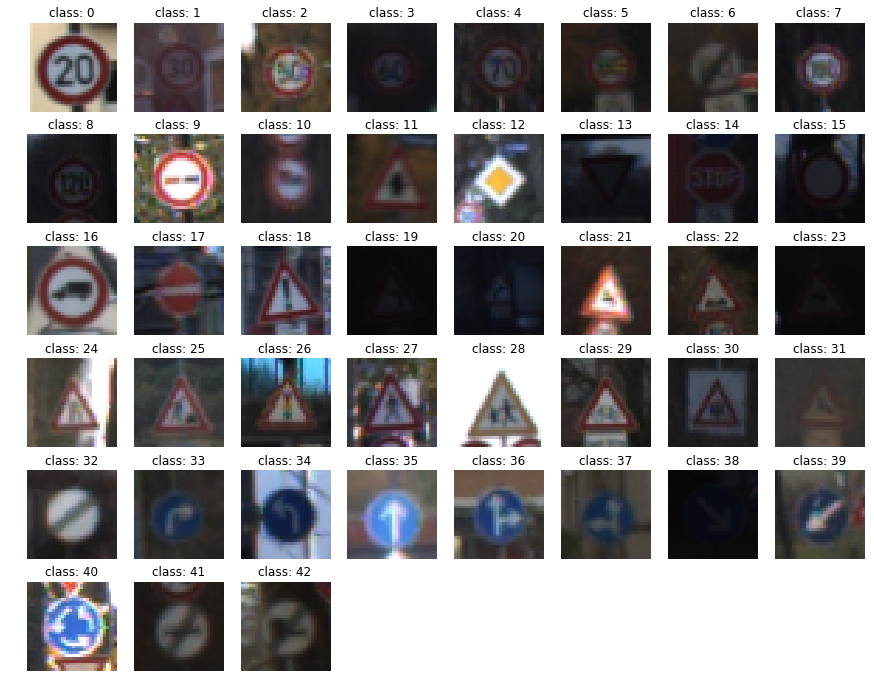

In [7]:
import random
import matplotlib.pyplot as plt
%matplotlib inline

train_samples_per_class=[]
test_samples_per_class=[]
plt.figure(figsize=(15, 12))

for i in range(0, n_classes):

    train_samples_per_class.append(len(X_train[y_train == i]))
    test_samples_per_class.append(len(X_test[y_test == i]))
    
    # Displaying the first image for each class
    plt.subplot(6, 8, i+1)
    plt.imshow(X_train[y_train == i][0, :, :, :]) 
    plt.title('class: ' + str(i))
    plt.axis('off')
    
plt.show()



### Include an exploratory visualization of the dataset

Visualize the German Traffic Signs Dataset using the pickled file(s). This is open ended, suggestions include: plotting traffic sign images, plotting the count of each sign, etc. 

The [Matplotlib](http://matplotlib.org/) [examples](http://matplotlib.org/examples/index.html) and [gallery](http://matplotlib.org/gallery.html) pages are a great resource for doing visualizations in Python.

**NOTE:** It's recommended you start with something simple first. If you wish to do more, come back to it after you've completed the rest of the sections. It can be interesting to look at the distribution of classes in the training, validation and test set. Is the distribution the same? Are there more examples of some classes than others?

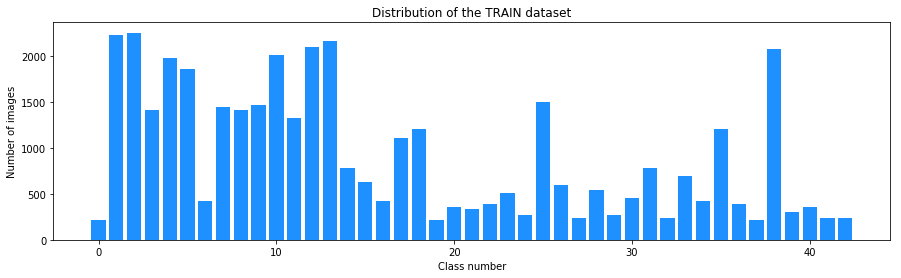

Images for Train dataset (before enlargement process):
Minimum for class = 210
Mean for class = 912
Maximum for class = 2250


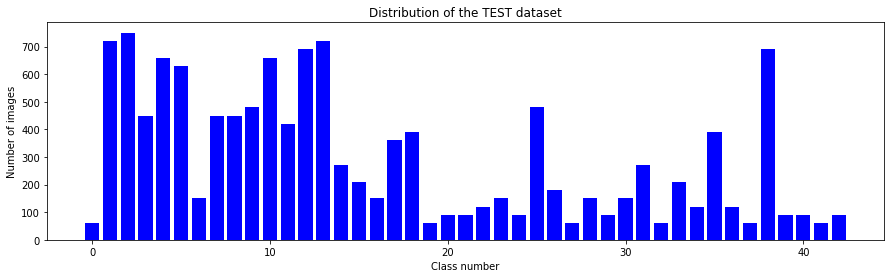

Images for Test dataset:
Minimum for class = 60
Mean for class = 294
Maximum for class = 750


In [8]:
### Data exploration visualization code goes here.

import matplotlib.pyplot as plt
# Visualizations will be shown in the notebook.
%matplotlib inline

plt.figure(figsize=(15, 4))
plt.bar(range(0, n_classes), train_samples_per_class, color='dodgerblue')
plt.title("Distribution of the TRAIN dataset")
plt.ylabel("Number of images")
plt.xlabel("Class number")
plt.show()

print("Images for Train dataset (before enlargement process):")
print("Minimum for class =", min(train_samples_per_class))
mean_training = np.mean(train_samples_per_class)
print("Mean for class =", '{0:.0f}'.format(mean_training))
print("Maximum for class =", max(train_samples_per_class))

plt.figure(figsize=(15, 4))
plt.bar(range(0, n_classes), test_samples_per_class, color ='b')
plt.title("Distribution of the TEST dataset")
plt.ylabel("Number of images")
plt.xlabel("Class number")
plt.show()

print("Images for Test dataset:")
print("Minimum for class =", min(test_samples_per_class))
print("Mean for class =", '{0:.0f}'.format(np.mean(test_samples_per_class)))
print("Maximum for class =", max(test_samples_per_class))

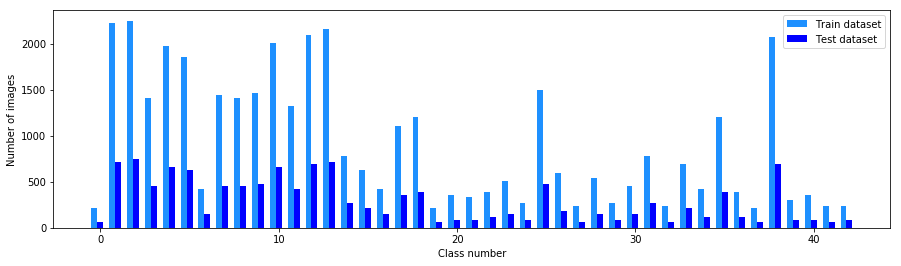

In [9]:
%matplotlib inline

indices = range(0, n_classes)
width = np.min(np.diff(indices))/3

fig = plt.figure(figsize=(15, 4))
ax = fig.add_subplot(111)
ax.bar(indices-width,train_samples_per_class,width,color='dodgerblue',label='Train dataset')
ax.bar(indices,test_samples_per_class,width,color='b',label='Test dataset')
ax.set_xlabel('Class number')
ax.set_ylabel('Number of images')
ax.legend()
plt.show()

----

## Step 2: Design and Test a Model Architecture

Design and implement a deep learning model that learns to recognize traffic signs. Train and test your model on the [German Traffic Sign Dataset](http://benchmark.ini.rub.de/?section=gtsrb&subsection=dataset).


### Pre-process the Data Set (normalization, grayscale, etc.)

Minimally, the image data should be normalized so that the data has mean zero and equal variance. For image data, `(pixel - 128)/ 128` is a quick way to approximately normalize the data and can be used in this project. 

Other pre-processing steps are optional. You can try different techniques to see if it improves performance. 

Use the code cell (or multiple code cells, if necessary) to implement the first step of your project.

In [10]:
import random
import matplotlib.pyplot as plt

X_train_sorted = np.zeros((0,32,32,3))
y_train_sorted = np.zeros((0))

    
for i in range(0, n_classes):
    # For later use, in order to add more images according to the amount of each class
    x_train_for_class_n = X_train[y_train == i]
    y_train_for_class_n = y_train[y_train == i]
    X_train_sorted = np.concatenate([X_train_sorted, x_train_for_class_n])
    y_train_sorted = np.concatenate([y_train_sorted, y_train_for_class_n])
    
    i_test = X_test[y_test == i]
    test_samples_per_class.append(len(i_test))

    
# Count the lower & upper bounds of each class
# in order to later multiply each class images to raise the amount of training samples
count_per_class = np.zeros([n_classes,2])
count_per_class[0,0] =0
count_per_class[0,1] =train_samples_per_class[0]

for i in range(1,n_classes):
    count_per_class[i,0] = count_per_class[i-1,1]+1
    count_per_class[i,1] = count_per_class[i,0]+train_samples_per_class[i]-1
print(count_per_class)


[[     0.    210.]
 [   211.   2430.]
 [  2431.   4680.]
 [  4681.   6090.]
 [  6091.   8070.]
 [  8071.   9930.]
 [  9931.  10350.]
 [ 10351.  11790.]
 [ 11791.  13200.]
 [ 13201.  14670.]
 [ 14671.  16680.]
 [ 16681.  18000.]
 [ 18001.  20100.]
 [ 20101.  22260.]
 [ 22261.  23040.]
 [ 23041.  23670.]
 [ 23671.  24090.]
 [ 24091.  25200.]
 [ 25201.  26400.]
 [ 26401.  26610.]
 [ 26611.  26970.]
 [ 26971.  27300.]
 [ 27301.  27690.]
 [ 27691.  28200.]
 [ 28201.  28470.]
 [ 28471.  29970.]
 [ 29971.  30570.]
 [ 30571.  30810.]
 [ 30811.  31350.]
 [ 31351.  31620.]
 [ 31621.  32070.]
 [ 32071.  32850.]
 [ 32851.  33090.]
 [ 33091.  33779.]
 [ 33780.  34199.]
 [ 34200.  35399.]
 [ 35400.  35789.]
 [ 35790.  35999.]
 [ 36000.  38069.]
 [ 38070.  38369.]
 [ 38370.  38729.]
 [ 38730.  38969.]
 [ 38970.  39209.]]


In [11]:
### Preprocess the data here.
import cv2
import numpy as np 

# All the images were also Transform to grayscale, since the accuracy of the model was higher this way (and it shorten the model runtime)
# from shape (32,32,3) to (32,32,1)
def gray_scale(X_input):
    X_output = np.zeros((len(X_input),32,32,1))
    for i in range(len(X_input)):
        img = X_input[i].squeeze()
        img=img.astype(np.uint8)
        X_output[i,:,:,0] = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    return X_output


def deformation(X_input):
    X_output = np.zeros_like(X_input)
    for i in range(len(X_input)):
        M = cv2.getRotationMatrix2D((16,16), (30 *(np.random.rand()-.5)), 1)
        M[0,2] = 4 *(np.random.rand()-.5)
        M[1,2] = 4 *(np.random.rand()-.5)
        imgswap = cv2.warpAffine(X_input[i], M, (32,32))
        trans = 2*(np.random.rand()-.5)
        pts1 = np.float32([[2,2],[30,2],[0,30],[30,30]])
        pts2 = np.float32([[trans,trans],[30+trans,trans],[trans,30+trans],[30+trans,30+trans]])
        M = cv2.getPerspectiveTransform(pts1,pts2)
        X_output[i,:,:,:] = cv2.warpPerspective(imgswap,M,(32,32))

    return X_output


The distribution of signs between classes is very high, and the variance gets up from 210 samples for the lower class to 2250 samples to the highest one.  
In order to raise the number of samples of the dataset, I Counted the lower & upper bounds of each class in order to  multiply each class images to raise the amount of training samples. 


In [12]:
# Data augmentation process:
X_train_aug = X_train_sorted
y_train_aug = y_train_sorted

for n in range(n_classes):
    start = int(count_per_class[n,0])
    end = int(count_per_class[n,1])
    X_swap =  X_train_sorted[start:end,:,:,:]
    labels = y_train_sorted[start:end]
    if train_samples_per_class[n] < mean_training:
        # concatenate transformation of the dataset to the new train_data
        X_train_aug = np.concatenate([X_train_aug,deformation(X_swap),deformation(X_swap)])
        y_train_aug = np.concatenate([y_train_aug,labels,labels])
        
    elif train_samples_per_class[n] < mean_training*2:
        X_train_aug = np.concatenate([X_train_aug,deformation(X_swap)])
        y_train_aug = np.concatenate([y_train_aug,labels])
        
    else:
        X_train_aug = np.concatenate([X_train_aug,deformation(X_swap)/2])
        y_train_aug = np.concatenate([y_train_aug,labels/2])


print(y_train_aug.shape)
print(X_train_aug.shape)  

(88850,)
(88850, 32, 32, 3)


In [13]:
# Transform to gray
X_train_gray = gray_scale(X_train_aug)
X_valid_gray = gray_scale(X_valid)
X_test_gray = gray_scale(X_test)

print(X_train_gray.shape)
print(X_train_gray.shape) 

(88850, 32, 32, 1)
(88850, 32, 32, 1)


Displaying the first image from each class after the dataset was transformed to grayscale:

/home/carnd/anaconda3/envs/carnd-term1/lib/python3.5/site-packages/ipykernel_launcher.py:10: VisibleDeprecationWarning: boolean index did not match indexed array along dimension 0; dimension is 88850 but corresponding boolean dimension is 39209
  # Remove the CWD from sys.path while we load stuff.


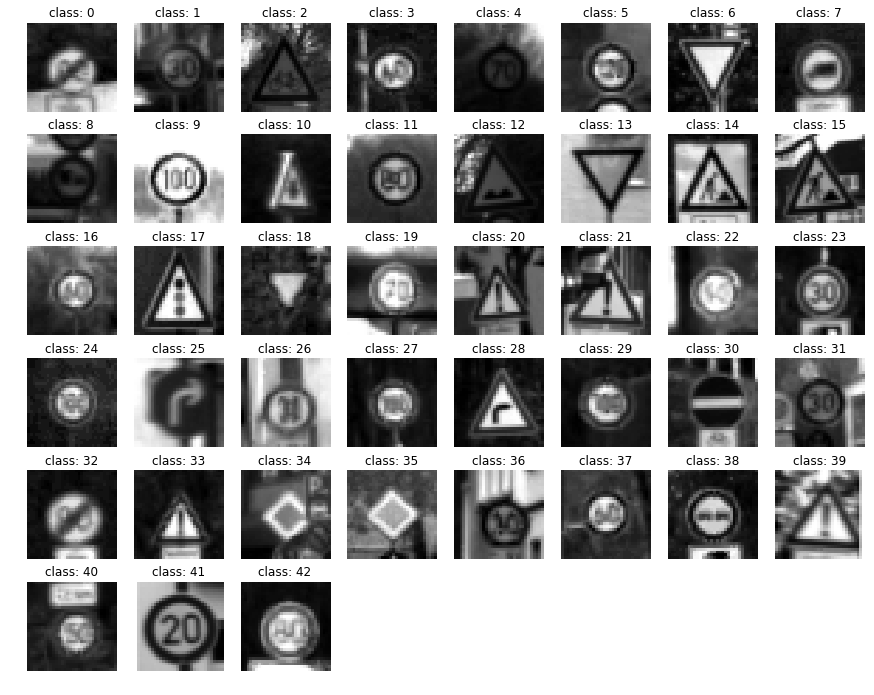

In [14]:
import random
import matplotlib.pyplot as plt
%matplotlib inline

plt.figure(figsize=(15, 12))

for i in range(0, n_classes):
    # Displaying the first image for each class
    plt.subplot(6, 8, i+1)
    img = X_train_gray[y_train == i][0, :, :, :]
    plt.imshow(img.squeeze(), cmap='gray') 
    plt.title('class: ' + str(i))
    plt.axis('off')
    
plt.show()

In [15]:
# Normalize images to [0,1]
X_train_norm= X_train_gray /255
X_valid_norm= X_valid_gray /255
X_test_norm= X_test_gray /255


# Shuffle 
from sklearn.utils import shuffle
X_train_shuffle, y_train_shuffle = shuffle(X_train_norm, y_train_aug)
X_test_ready, y_test_ready = shuffle (X_test_norm, y_test)


# Split training and validation
n_train=len(X_train_shuffle)
limRange = int(n_train*0.8)

X_train_ready = (X_train_shuffle[0:limRange+1])
X_valid_ready = (X_train_shuffle[limRange+1:n_train+1])
y_train_ready = y_train_shuffle[0:limRange+1]
y_valid_ready = y_train_shuffle[limRange+1:n_train+1]

  
print("X_train original shape: ", X_train.shape)
print("y_train original shape: ", y_train.shape)
print()
print("X_train_ready shape ", X_train_ready.shape)
print("y_train_ready shape ",y_train_ready.shape)
print()
print("X_valid_ready shape ", X_valid_ready.shape)
print("y_valid_ready shape ",y_valid_ready.shape)
print()
print("X_test_ready shape ", X_test_ready.shape)
print("y_test_ready shape ",y_test_ready.shape)

X_train original shape:  (39209, 32, 32, 3)
y_train original shape:  (39209,)

X_train_ready shape  (71081, 32, 32, 1)
y_train_ready shape  (71081,)

X_valid_ready shape  (17769, 32, 32, 1)
y_valid_ready shape  (17769,)

X_test_ready shape  (12630, 32, 32, 1)
y_test_ready shape  (12630,)


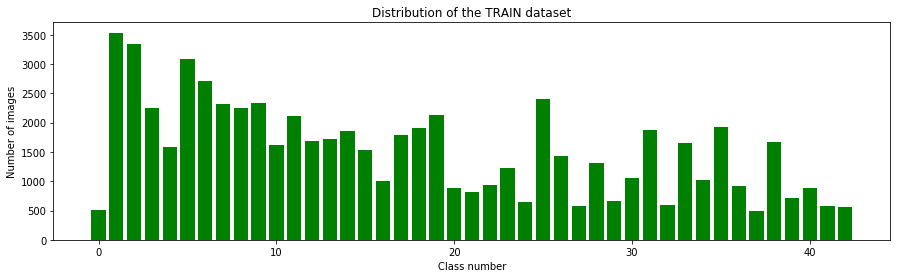

Images for Train dataset (After enlargement process):
Minimum for class = 489
Mean for class = 1538
Maximum for class = 3534


In [16]:
import matplotlib.pyplot as plt
# Visualizations will be shown in the notebook.
%matplotlib inline

new_train_samples_per_class=[]

for i in range(0, n_classes):
    i_train = X_train_ready[y_train_ready == i]
    new_train_samples_per_class.append(len(i_train))
    
plt.figure(figsize=(15, 4))
plt.bar(range(0, n_classes), new_train_samples_per_class, color ='g')
plt.title("Distribution of the TRAIN dataset")
plt.ylabel("Number of images")
plt.xlabel("Class number")
plt.show()

print("Images for Train dataset (After enlargement process):")
print("Minimum for class =", min(new_train_samples_per_class))
print("Mean for class =", '{0:.0f}'.format(np.mean(new_train_samples_per_class)))
print("Maximum for class =", max(new_train_samples_per_class))


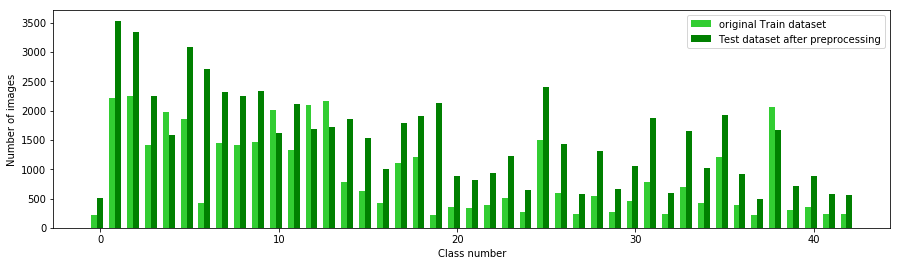

In [17]:
%matplotlib inline

indices = range(0, n_classes)
width = np.min(np.diff(indices))/3

fig = plt.figure(figsize=(15, 4))
ax = fig.add_subplot(111)
ax.bar(indices-width,train_samples_per_class,width,color='limegreen',label='original Train dataset')
ax.bar(indices,new_train_samples_per_class,width,color='g',label='Test dataset after preprocessing')
ax.set_xlabel('Class number')
ax.set_ylabel('Number of images')
ax.legend()
plt.show()

### Model Architecture

My model consisted of the following layers:

![model](readme_img/model.jpg)

In [18]:
def Model(x):    

    mu = 0
    sigma = 0.1
    keep_prob = 0.9
    strides_conv = [1, 1, 1, 1]
    strides_pool = [1, 2, 2, 1]
    
    #________________________________Layer 1__________________________________________________

    # Convolutional. Input = 32x32x1. Filter = 5x5x1. Output = 28x28x6.
    # Arguments used for tf.truncated_normal, randomly defines variables for the weights and biases for each layer
    conv1_W = tf.Variable(tf.random_normal(shape=(5, 5, 1, 6), mean = mu, stddev = sigma))
    conv1_b = tf.Variable(tf.zeros(6))
    conv1   = tf.nn.conv2d(x, conv1_W, strides=strides_conv, padding='VALID') + conv1_b

    # Apply activation function
    conv1 = tf.nn.relu(conv1)
    #conv1 = tf.nn.dropout(conv1, keep_prob)

    #________________________________Layer 2__________________________________________________
    
     # Convolutional. Input = 28x28x6. Filter = 3x3x6. Output = 14x14x6.
    conv2_W = tf.Variable(tf.random_normal(shape=(3, 3, 6, 12), mean = mu, stddev = sigma))
    conv2_b = tf.Variable(tf.zeros(12))
    conv2   = tf.nn.conv2d(conv1, conv2_W, strides=strides_conv, padding='SAME') + conv2_b

    # Pooling. Input = 28x28x6. Output = 14x14x6.
    conv2 = tf.nn.max_pool(conv2, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='VALID')

    #________________________________Layer 3__________________________________________________

    # Convolutional. Input = 14x14x6. Filter = 5x5x12. Output = 10x10x16.
    conv3_W = tf.Variable(tf.truncated_normal(shape=(5, 5, 12, 16), mean = mu, stddev = sigma))
    conv3_b = tf.Variable(tf.zeros(16))
    conv3   = tf.nn.conv2d(conv2, conv3_W, strides=strides_conv, padding='VALID') + conv3_b
    
    # Apply activation function
    conv3 = tf.nn.relu(conv3)

    # Pooling. Input = 10x10x16. Output = 5x5x16.
    conv3 = tf.nn.max_pool(conv3, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='VALID')

    #________________________________Layer 4__________________________________________________
    
    # Flatten. Input = 5x5x16. Output = 400.
    fc0   = tf.reshape(conv3, [-1, int(5*5*16)])
    fc0 = tf.nn.dropout(fc0, keep_prob)
    
    # Fully Connected. Input = 400. Output = 120.
    fc1_W = tf.Variable(tf.truncated_normal(shape=(400, 120), mean = mu, stddev = sigma))
    fc1_b = tf.Variable(tf.zeros(120))
    fc1   = tf.matmul(fc0, fc1_W) + fc1_b
    
    # Apply activation function
    fc1 = tf.nn.relu(fc1)
    fc1 = tf.nn.dropout(fc1, keep_prob)

    #________________________________Layer 5__________________________________________________
        
    # Fully Connected. Input = 120. Output = 84.
    fc2_W  = tf.Variable(tf.truncated_normal(shape=(120, 84), mean = mu, stddev = sigma))
    fc2_b  = tf.Variable(tf.zeros(84))
    fc2    = tf.matmul(fc1, fc2_W) + fc2_b
    
    # Apply activation function
    fc2  = tf.nn.relu(fc2)
    fc2  = tf.nn.dropout(fc2, keep_prob)

    #________________________________Layer 6__________________________________________________
    
    # Fully Connected. Input = 84. Output = 43.
    fc3_W  = tf.Variable(tf.truncated_normal(shape=(84, n_classes), mean = mu, stddev = sigma))
    fc3_b  = tf.Variable(tf.zeros(n_classes))
    logits = tf.matmul(fc2, fc3_W) + fc3_b
    
    return logits

## Features and Labels

`x` is a placeholder for a batch of input images.
`y` is a placeholder for a batch of output labels.


In [19]:
import tensorflow as tf
x = tf.placeholder(tf.float32, (None, 32, 32, 1))
y = tf.placeholder(tf.int32, (None))
one_hot_y = tf.one_hot(y, n_classes)

### Train, Validate and Test the Model

A validation set can be used to assess how well the model is performing. A low accuracy on the training and validation
sets imply underfitting. A high accuracy on the training set but low accuracy on the validation set implies overfitting.

To train the model, I used LeNet architecture as a baseline, with additional 2D Convolution layer and a couple of parameter tunning. batch size was set to 100, and I also used 100 epochs. The learning rate (0.001), mean (0) and sigma (0.1) were left with their default values.

In [20]:
rate = 0.001

logits = Model(x)
cross_entropy = tf.nn.softmax_cross_entropy_with_logits(labels=one_hot_y, logits=logits)
loss_operation = tf.reduce_mean(cross_entropy)
optimizer = tf.train.AdamOptimizer(learning_rate = rate)
training_operation = optimizer.minimize(loss_operation)

## Model Evaluation
Evaluate how well the loss and accuracy of the model for a given dataset.


In [21]:
correct_prediction = tf.equal(tf.argmax(logits, 1), tf.argmax(one_hot_y, 1))
accuracy_operation = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))
saver = tf.train.Saver()

BATCH_SIZE = 100

def evaluate(X_data, y_data):
    num_examples = len(X_data)
    total_accuracy = 0
    sess = tf.get_default_session()
    for offset in range(0, num_examples, BATCH_SIZE):
        batch_x, batch_y = X_data[offset:offset+BATCH_SIZE], y_data[offset:offset+BATCH_SIZE]
        accuracy = sess.run(accuracy_operation, feed_dict={x: batch_x, y: batch_y})
        total_accuracy += (accuracy * len(batch_x))
    return total_accuracy / num_examples

In [22]:
from time import time
start_time = time()

EPOCHS = 60

with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    num_examples = len(X_train_ready)

    print("Training...")
    print()
    for i in range(EPOCHS):
        X_shuff, y_shuff = shuffle(X_train_ready, y_train_ready)
        for offset in range(0, num_examples, BATCH_SIZE):
            end = offset + BATCH_SIZE
            batch_x, batch_y = X_shuff[offset:end], y_shuff[offset:end]
            sess.run(training_operation, feed_dict={x: batch_x, y: batch_y})

        validation_accuracy = evaluate(X_valid_ready, y_valid_ready)
        
        print("EPOCH {} ...".format(i+1))
        print("Validation Accuracy = {:.3f}".format(validation_accuracy))
        print()

    saver.save(sess, 'model')
    print("Model saved")    
    print("Final Validation Accuracy = {:.3f}".format(validation_accuracy))

total_time = time() - start_time
minutes, seconds = divmod(total_time, 60)
print ("Total time for model training: ", minutes, "min, {:.0f}".format(seconds),  "s ")

Training...

EPOCH 1 ...
Validation Accuracy = 0.618

EPOCH 2 ...
Validation Accuracy = 0.741

EPOCH 3 ...
Validation Accuracy = 0.789

EPOCH 4 ...
Validation Accuracy = 0.827

EPOCH 5 ...
Validation Accuracy = 0.851

EPOCH 6 ...
Validation Accuracy = 0.862

EPOCH 7 ...
Validation Accuracy = 0.874

EPOCH 8 ...
Validation Accuracy = 0.876

EPOCH 9 ...
Validation Accuracy = 0.889

EPOCH 10 ...
Validation Accuracy = 0.901

EPOCH 11 ...
Validation Accuracy = 0.902

EPOCH 12 ...
Validation Accuracy = 0.908

EPOCH 13 ...
Validation Accuracy = 0.911

EPOCH 14 ...
Validation Accuracy = 0.911

EPOCH 15 ...
Validation Accuracy = 0.915

EPOCH 16 ...
Validation Accuracy = 0.922

EPOCH 17 ...
Validation Accuracy = 0.922

EPOCH 18 ...
Validation Accuracy = 0.924

EPOCH 19 ...
Validation Accuracy = 0.925

EPOCH 20 ...
Validation Accuracy = 0.928

EPOCH 21 ...
Validation Accuracy = 0.932

EPOCH 22 ...
Validation Accuracy = 0.934

EPOCH 23 ...
Validation Accuracy = 0.933

EPOCH 24 ...
Validation Accura

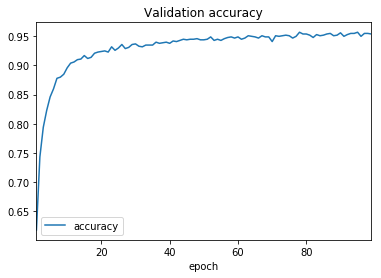

In [35]:
import pandas as pd
%matplotlib inline

training_results = pd.read_csv('accuracy_per_epoch.csv')
training_results.plot(x='epoch', y='accuracy', title='Validation accuracy')

Training was performed on an Amazon g2.2xlarge GPU server, and it took about 11 minutes.

My final model results were:
* training set accuracy of 96.2%
* validation set accuracy of 95.2%
* test set accuracy of 93.4%

---

## Step 3: Test a Model on New Images

To give yourself more insight into how your model is working, download at least five pictures of German traffic signs from the web and use your model to predict the traffic sign type.

You may find `signnames.csv` useful as it contains mappings from the class id (integer) to the actual sign name.

### Load and Output the Images

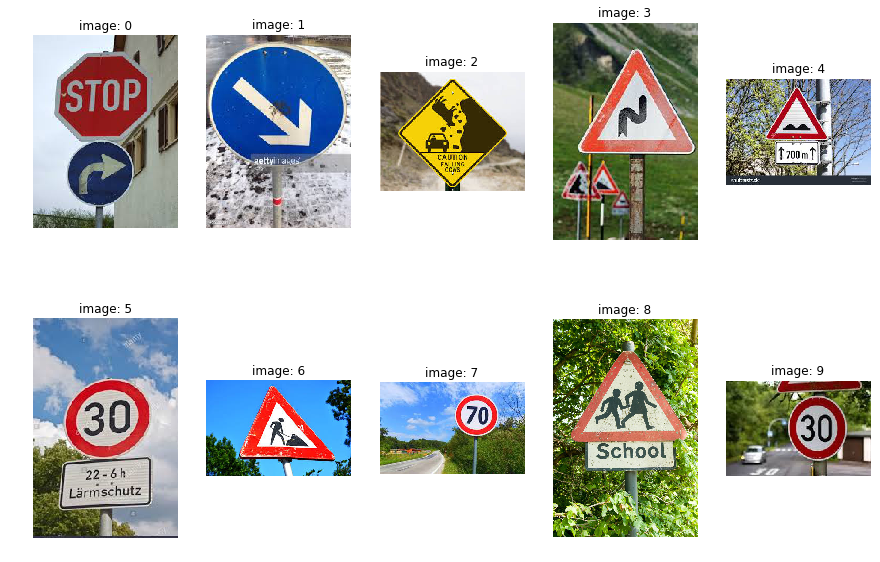

In [51]:
import cv2
import os
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np 

images = []
images_orig = []
folder = "new_images/"
for image_name in os.listdir(folder):
    #reading in an image and resize it
    image = mpimg.imread(folder + image_name)
    images_orig.append(image)
    
    image = cv2.imread(folder + image_name,0)
    image = cv2.resize(image, (32,32))
    image = image/255
    images.append(image)
    
plt.figure(figsize=(15, 10))
for i in range(len(images)):
   # Displaying the images 
    plt.subplot(2, len(images)/2, i+1)
    plt.imshow(images_orig[i]) 
    plt.title('image: ' + str(i))
    plt.axis('off')

### Predict the Sign Type for Each Image

New images after reshape:  (10, 32, 32, 1)


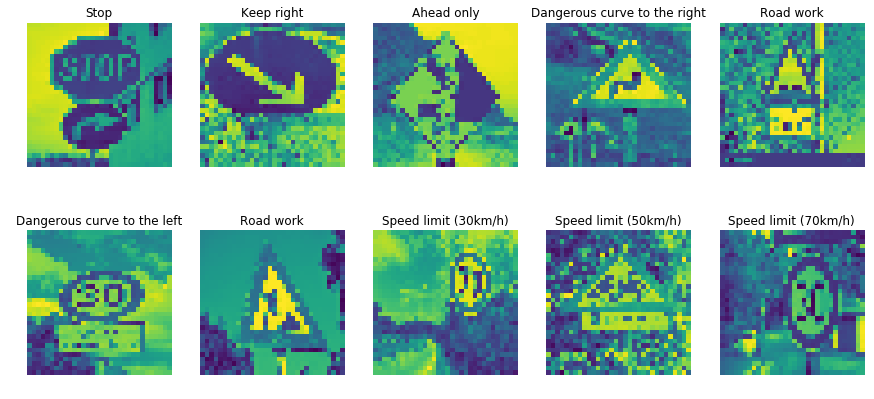

In [53]:
### Run the predictions here and use the model to output the prediction for each image.
### Make sure to pre-process the images with the same pre-processing pipeline used earlier.
import numpy as np
import csv

X_data = np.asarray(images)
X_data = X_data.reshape((len(images),32,32,1))
print ("New images after reshape: ", X_data.shape)

signs=[]
with open('signnames.csv', 'rt') as csvfile:
    reader = csv.DictReader(csvfile, delimiter=',')
    for row in reader:
        signs.append((row['SignName']))
        
with tf.Session() as sess:
    sess = tf.get_default_session()
    saver.restore(sess, tf.train.latest_checkpoint('.'))
    signs_classes = sess.run(tf.argmax(logits, 1), feed_dict={x: X_data})

plt.figure(figsize=(15, 7))
for i in range(len(images)):
    plt.subplot(2, len(images)/2, i+1)
    plt.imshow(images[i]) 
    plt.title(signs[signs_classes[i]])
    plt.axis('off')
plt.show()

Here are the results of the prediction:

![image.png](readme_img/predictions_table.jpg)

### Analyze Performance

actual results: [14, 38, -1, 21, 22, 1, 25, 4, 28, 1]
model prediction: [14, 38, 35, 20, 21, 19, 25, 4, 2, 1]


/home/carnd/anaconda3/envs/carnd-term1/lib/python3.5/site-packages/matplotlib/axes/_axes.py:518: UserWarning: You have mixed positional and keyword arguments, some input will be discarded.
  warnings.warn("You have mixed positional and keyword "


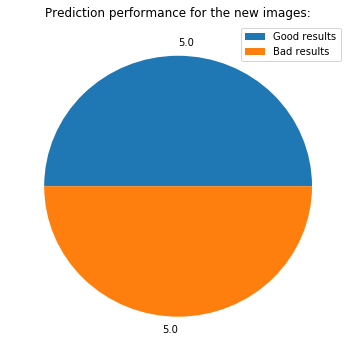

In [80]:
### Calculate the accuracy for these 5 new images. 
### For example, if the model predicted 1 out of 5 signs correctly, it's 20% accurate on these new images.
import matplotlib.pyplot as plt
%matplotlib inline

y_actual =[14, 38, -1, 21, 22, 1, 25, 4, 28, 1]
y_prediction = signs_classes

print("actual results:", y_actual)
print("model prediction:", y_prediction)

prediction_statistics = np.zeros(2)
for i in range(len(images)):
    if y_actual[i] == y_prediction[i]:
        prediction_statistics[0] += 1
    else:
        prediction_statistics[1] += 1

lables =  str(prediction_statistics[0]),str(prediction_statistics[1])
legend_lables = 'Good results','Bad results'

plt.rcParams["figure.figsize"] = (6,6)
plt.title("Prediction performance for the new images:")
patches = plt.pie(prediction_statistics, labels = lables)
plt.legend(patches, labels=legend_lables, loc="upper right")


### Output Top 5 Softmax Probabilities For Each Image Found on the Web

For each of the new images, print out the model's softmax probabilities to show the **certainty** of the model's predictions (limit the output to the top 5 probabilities for each image). [`tf.nn.top_k`](https://www.tensorflow.org/versions/r0.12/api_docs/python/nn.html#top_k) could prove helpful here. 

The example below demonstrates how tf.nn.top_k can be used to find the top k predictions for each image.

`tf.nn.top_k` will return the values and indices (class ids) of the top k predictions. So if k=3, for each sign, it'll return the 3 largest probabilities (out of a possible 43) and the correspoding class ids.

Take this numpy array as an example. The values in the array represent predictions. The array contains softmax probabilities for five candidate images with six possible classes. `tk.nn.top_k` is used to choose the three classes with the highest probability:

```
# (5, 6) array
a = np.array([[ 0.24879643,  0.07032244,  0.12641572,  0.34763842,  0.07893497,
         0.12789202],
       [ 0.28086119,  0.27569815,  0.08594638,  0.0178669 ,  0.18063401,
         0.15899337],
       [ 0.26076848,  0.23664738,  0.08020603,  0.07001922,  0.1134371 ,
         0.23892179],
       [ 0.11943333,  0.29198961,  0.02605103,  0.26234032,  0.1351348 ,
         0.16505091],
       [ 0.09561176,  0.34396535,  0.0643941 ,  0.16240774,  0.24206137,
         0.09155967]])
```

Running it through `sess.run(tf.nn.top_k(tf.constant(a), k=3))` produces:

```
TopKV2(values=array([[ 0.34763842,  0.24879643,  0.12789202],
       [ 0.28086119,  0.27569815,  0.18063401],
       [ 0.26076848,  0.23892179,  0.23664738],
       [ 0.29198961,  0.26234032,  0.16505091],
       [ 0.34396535,  0.24206137,  0.16240774]]), indices=array([[3, 0, 5],
       [0, 1, 4],
       [0, 5, 1],
       [1, 3, 5],
       [1, 4, 3]], dtype=int32))
```

Looking just at the first row we get `[ 0.34763842,  0.24879643,  0.12789202]`, you can confirm these are the 3 largest probabilities in `a`. You'll also notice `[3, 0, 5]` are the corresponding indices.

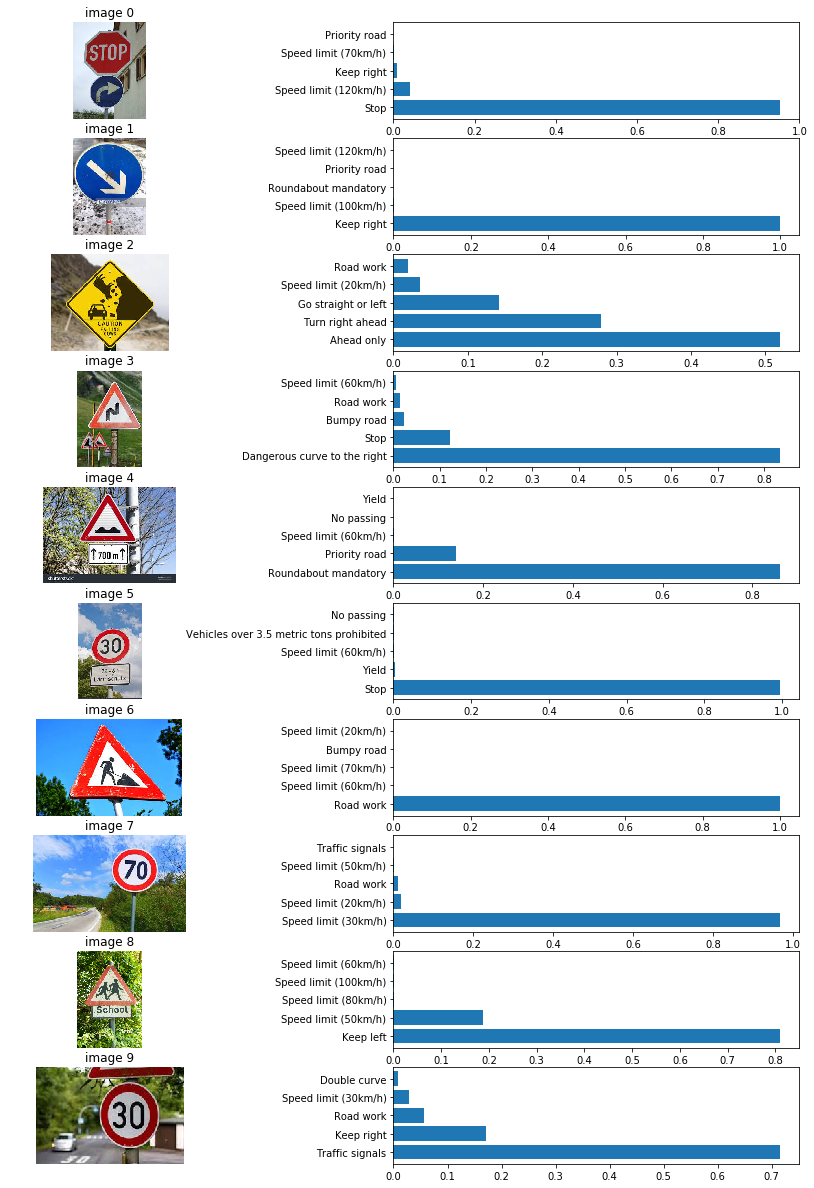

In [63]:
### Print out the top five softmax probabilities for the predictions on the German traffic sign images found on the web. 
### Feel free to use as many code cells as needed.
      
with tf.Session() as sess:
    sess = tf.get_default_session()
    saver.restore(sess, tf.train.latest_checkpoint('.'))
    prob = sess.run(tf.nn.softmax(logits), feed_dict={x: X_data})
    top_5 = tf.nn.top_k(prob, k=5)
    top_5_prob = sess.run(top_5)

size= len(images)    
plt.figure(figsize=(16, 21))
for i in range(size):
    plt.subplot(size, 2, 2*i +1)
    plt.imshow(images_orig[i]) 
    plt.title("image " + str(i))
    plt.axis('off')
    
    plt.subplot(size, 2, 2*i +2)
    plt.barh(np.arange(1, 6, 1), top_5_prob.values[i, :])
    result=[signs[k] for k in top_5_prob.indices[i]]
    plt.yticks(np.arange(1, 6, 1), result)
plt.show()

For almost all the images the predictor was very certain with probability of more than 50%, even when the results were wrong.

I noticed that for some of the images - I got different predictions each time I ran the model (also with high probability on them) which is quite strange

For the images that were predict correctly we can observe probability of more than 90% which is preety satisfying.

### Project Writeup

Once you have completed the code implementation, document your results in a project writeup using this [template](https://github.com/udacity/CarND-Traffic-Sign-Classifier-Project/blob/master/writeup_template.md) as a guide. The writeup can be in a markdown or pdf file. 

> **Note**: Once you have completed all of the code implementations and successfully answered each question above, you may finalize your work by exporting the iPython Notebook as an HTML document. You can do this by using the menu above and navigating to  \n",
    "**File -> Download as -> HTML (.html)**. Include the finished document along with this notebook as your submission.

---

## Step 4 (Optional): Visualize the Neural Network's State with Test Images

 This Section is not required to complete but acts as an additional excersise for understaning the output of a neural network's weights. While neural networks can be a great learning device they are often referred to as a black box. We can understand what the weights of a neural network look like better by plotting their feature maps. After successfully training your neural network you can see what it's feature maps look like by plotting the output of the network's weight layers in response to a test stimuli image. From these plotted feature maps, it's possible to see what characteristics of an image the network finds interesting. For a sign, maybe the inner network feature maps react with high activation to the sign's boundary outline or to the contrast in the sign's painted symbol.

 Provided for you below is the function code that allows you to get the visualization output of any tensorflow weight layer you want. The inputs to the function should be a stimuli image, one used during training or a new one you provided, and then the tensorflow variable name that represents the layer's state during the training process, for instance if you wanted to see what the [LeNet lab's](https://classroom.udacity.com/nanodegrees/nd013/parts/fbf77062-5703-404e-b60c-95b78b2f3f9e/modules/6df7ae49-c61c-4bb2-a23e-6527e69209ec/lessons/601ae704-1035-4287-8b11-e2c2716217ad/concepts/d4aca031-508f-4e0b-b493-e7b706120f81) feature maps looked like for it's second convolutional layer you could enter conv2 as the tf_activation variable.

For an example of what feature map outputs look like, check out NVIDIA's results in their paper [End-to-End Deep Learning for Self-Driving Cars](https://devblogs.nvidia.com/parallelforall/deep-learning-self-driving-cars/) in the section Visualization of internal CNN State. NVIDIA was able to show that their network's inner weights had high activations to road boundary lines by comparing feature maps from an image with a clear path to one without. Try experimenting with a similar test to show that your trained network's weights are looking for interesting features, whether it's looking at differences in feature maps from images with or without a sign, or even what feature maps look like in a trained network vs a completely untrained one on the same sign image.

<figure>
 <img src="readme_img/visualize_cnn.png" width="380" alt="Combined Image" />
 <figcaption>
 <p></p> 
 <p style="text-align: center;"> Your output should look something like this (above)</p> 
 </figcaption>
</figure>
 <p></p> 


In [65]:
### Visualize your network's feature maps here.
### Feel free to use as many code cells as needed.

# image_input: the test image being fed into the network to produce the feature maps
# tf_activation: should be a tf variable name used during your training procedure that represents the calculated state of a specific weight layer
# activation_min/max: can be used to view the activation contrast in more detail, by default matplot sets min and max to the actual min and max values of the output
# plt_num: used to plot out multiple different weight feature map sets on the same block, just extend the plt number for each new feature map entry
def outputFeatureMap(image_input, tf_activation, activation_min=-1, activation_max=-1 ,plt_num=1):
    # Here make sure to preprocess your image_input in a way your network expects
    # with size, normalization, ect if needed
    # image_input =
    # Note: x should be the same name as your network's tensorflow data placeholder variable
    # If you get an error tf_activation is not defined it may be having trouble accessing the variable from inside a function
    activation = tf_activation.eval(session=sess,feed_dict={x : image_input})
    featuremaps = activation.shape[3]
    plt.figure(plt_num, figsize=(15,15))
    for featuremap in range(featuremaps):
        plt.subplot(6,8, featuremap+1) # sets the number of feature maps to show on each row and column
        plt.title('FeatureMap ' + str(featuremap)) # displays the feature map number
        if activation_min != -1 & activation_max != -1:
            plt.imshow(activation[0,:,:, featuremap], interpolation="nearest", vmin =activation_min, vmax=activation_max, cmap="gray")
        elif activation_max != -1:
            plt.imshow(activation[0,:,:, featuremap], interpolation="nearest", vmax=activation_max, cmap="gray")
        elif activation_min !=-1:
            plt.imshow(activation[0,:,:, featuremap], interpolation="nearest", vmin=activation_min, cmap="gray")
        else:
            plt.imshow(activation[0,:,:, featuremap], interpolation="nearest", cmap="gray")

In [67]:
img = X_data[0]
imgs = np.array([img])
print(X_data.shape)

def get_conv2(x):
    mu = 0
    sigma = 0.1
    keep_prob = 0.9
    strides_conv = [1, 1, 1, 1]
    strides_pool = [1, 2, 2, 1]

    #________________________________Layer 1__________________________________________________

    # Convolutional. Input = 32x32x1. Filter = 5x5x3. Output = 28x28x6.
    # Arguments used for tf.truncated_normal, randomly defines variables for the weights and biases for each layer
    conv1_W = tf.Variable(tf.random_normal(shape=(5, 5, 1, 6), mean = mu, stddev = sigma))
    conv1_b = tf.Variable(tf.zeros(6))
    conv1   = tf.nn.conv2d(x, conv1_W, strides=strides_conv, padding='VALID') + conv1_b

    # Apply activation function
    conv1 = tf.nn.relu(conv1)
    #conv1 = tf.nn.dropout(conv1, keep_prob)

    conv2_W = tf.Variable(tf.random_normal(shape=(3, 3, 6, 12), mean = mu, stddev = sigma))
    conv2_b = tf.Variable(tf.zeros(12))
    conv2   = tf.nn.conv2d(conv1, conv2_W, strides=strides_conv, padding='SAME') + conv2_b
    return conv2

x = tf.placeholder(tf.float32, (None, 32, 32, 1))
conv2 = get_conv2(x)

with tf.Session() as sess:
    outputFeatureMap(X_data, conv2)


(10, 32, 32, 1)


In [ ]:
# Close the current session.
sess.close()